In [1]:
import xarray
import matplotlib.pyplot as plt
import numpy as np
from clim_recal.utils.core import climate_data_mount_path
from matplotlib.axes import Axes
import pandas as pd

RUN_VARS = ["01", "05", "06", "07", "08"]
VARS = ["tasmax", "tasmin", "pr"]

In [2]:
def add_cols(df):
    df["day"] = df["time"].apply(lambda x: x.timetuple().tm_yday)
    df["month"] = df["time"].apply(lambda x: x.month)
    df["year"] = df["time"].apply(lambda x: x.year)
    df["day_of_month"] = df["time"].apply(lambda x: x.day)
    df["leap_year"] = df["time"].apply(lambda x: x.year % 4 == 0)
    return df


def get_days(is_leap_year: bool) -> np.array:
    if not is_leap_year:
        # https://docs.xarray.dev/en/stable/generated/xarray.Dataset.convert_calendar.html
        #  February 6th (36), April 19th (109), July 2nd (183), September 12th (255), November 25th (329).
        # First missing day should be 37
        return np.array([37, 109, 183, 255, 329])
    else:
        # January 31st (31), March 31st (91), June 1st (153), July 31st (213), September 31st (275) and November 30th (335).
        return np.array([31, 91, 153, 213, 275, 335])


def get_data() -> dict[str, dict[str, tuple[pd.DataFrame, pd.DataFrame]]]:
    data = {}
    for var in VARS:
        data[var] = {}
        for run_var in RUN_VARS:
            path_raw = f"{climate_data_mount_path()}/processed_2024_09_26/cpm-raw-medians/median-{var}-{run_var}.nc"
            path_con = f"{climate_data_mount_path()}/processed_2024_09_26/cpm-converted-medians/median-{var}-{run_var}.nc"
            x_raw = xarray.load_dataset(path_raw)
            x_con = xarray.load_dataset(path_con)
            df_raw = add_cols(
                x_raw.convert_calendar("standard", align_on="year")
                .to_pandas()
                .reset_index()
            )
            df_con = add_cols(x_con.to_pandas().reset_index())
            data[var][run_var] = (df_raw, df_con)
    return data

In [3]:
# Load all data
data = get_data()

Warning 3: Cannot find header.dxf (GDAL_DATA is not defined)


In [4]:
# Example
var, run_var = "tasmax", "01"
df_raw, df_con = data[var][run_var]

In [5]:
# Missing Day 37
df_raw.iloc[64:70]

,time,tasmax,day,month,year,day_of_month,leap_year
64,1981-02-04 12:00:00,7.901025,35,2,1981,4,False
65,1981-02-05 12:00:00,9.846338,36,2,1981,5,False
66,1981-02-07 12:00:00,10.244776,38,2,1981,7,False
67,1981-02-08 12:00:00,7.123193,39,2,1981,8,False
68,1981-02-09 12:00:00,7.830713,40,2,1981,9,False
69,1981-02-10 12:00:00,7.916040,41,2,1981,10,False


In [6]:
def plot_by_day(
    data,
    var: str,
    run_var: str,
    year: int,
    leap_year: bool,
    plot_diff: bool,
    ax: Axes,
    lw=0.8,
):
    df_raw, df_con = data[var][run_var]
    if not plot_diff:
        for i, df in enumerate([df_raw, df_con]):
            if leap_year is not None:
                df2 = df[df["leap_year"].eq(leap_year)]
            else:
                df2 = df
            if year is None:
                x = df2.groupby("day")[var].median()
            else:
                x = df2[df2["year"].eq(year)].groupby("day")[var].first()
            x = df2.groupby("day")[var].first()
            x = df2.groupby("day")[var].median()
            _sd = df2.groupby("day")[var].std()
            if i == 0:
                if leap_year is not None:
                    # x.index = x.index + get_offsets(leap_year)
                    ax.vlines(
                        get_days(leap_year),
                        x.min(),
                        x.max(),
                        zorder=-1,
                        lw=0.4,
                        color="k",
                        ls=":",
                    )
                ax.plot(x.index, x, lw=lw, alpha=0.8)
            else:
                ax.plot(x.index, x, lw=lw, alpha=0.8)
                # pass
    else:
        series = []
        for i, df in enumerate([df_raw, df_con]):
            if leap_year is not None:
                df2 = df[df["leap_year"].eq(leap_year)]
            else:
                df2 = df
            if year is None:
                x = df2.groupby("day")[var].median()
            else:
                x = df2[df2["year"].eq(year)].groupby("day")[var].first()

            if i == 0:
                if leap_year is not None:
                    # x.index = x.index + get_offsets(leap_year)
                    pass

            series.append(x)

        # Proportion difference
        # x2 = (series[1] - series[0]) / series[0]
        # Use absolute difference
        x2 = series[1] - series[0]

        ax.vlines(
            get_days(leap_year),
            x2.min(),
            x2.max(),
            zorder=-1,
            lw=0.4,
            color="k",
            ls=":",
        )
        ax.plot(x2.index, x2, lw=lw, alpha=0.8)

    ax.set_title(f"Year: {year}, Leap year: {leap_year}")
    if not plot_diff:
        ax.set_ylabel(f"Absolute difference ({var})")
    else:
        ax.set_ylabel(f"Value ({var})")

In [7]:
def plot_array(data, year, leap_year=True, plot_diff=False, lw=0.8):
    run_vars = ["01", "05", "06", "07", "08"]
    vars = ["tasmax", "tasmin", "pr"]
    fig, axs = plt.subplots(
        len(vars),
        len(run_vars),
        squeeze=False,
        sharex=True,
        sharey="row",
        figsize=(14, 6),
    )
    for row, var in enumerate(vars):
        for col, run_var in enumerate(run_vars):
            ax = axs[row][col]
            plot_by_day(data, var, run_var, year, leap_year, plot_diff, ax=ax, lw=lw)
            if col == 0:
                ax.set_ylabel(var, fontsize="medium")
            else:
                ax.set_ylabel("")
            if row == 0:
                ax.set_title(f"Run: {run_var}", fontsize="medium")
            else:
                ax.set_title("")

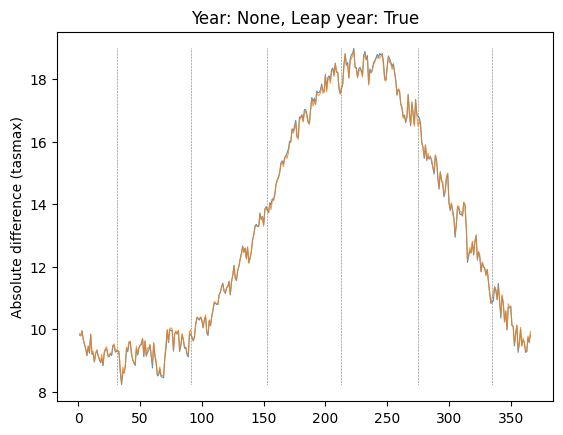

In [8]:
plot_by_day(data, "tasmax", "08", None, leap_year=True, plot_diff=False, ax=plt.gca())

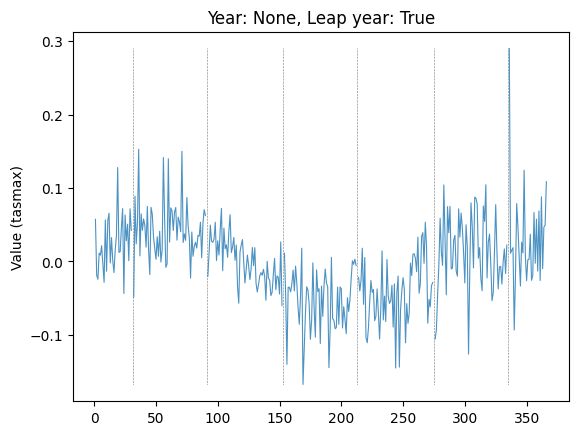

In [9]:
plot_by_day(data, "tasmax", "08", None, leap_year=True, plot_diff=True, ax=plt.gca())

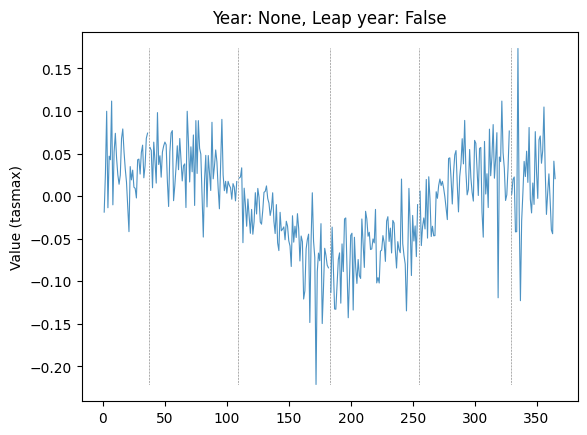

In [10]:
plot_by_day(data, "tasmax", "08", None, leap_year=False, plot_diff=True, ax=plt.gca())

Plot diff: False; year: None; leap_year: True


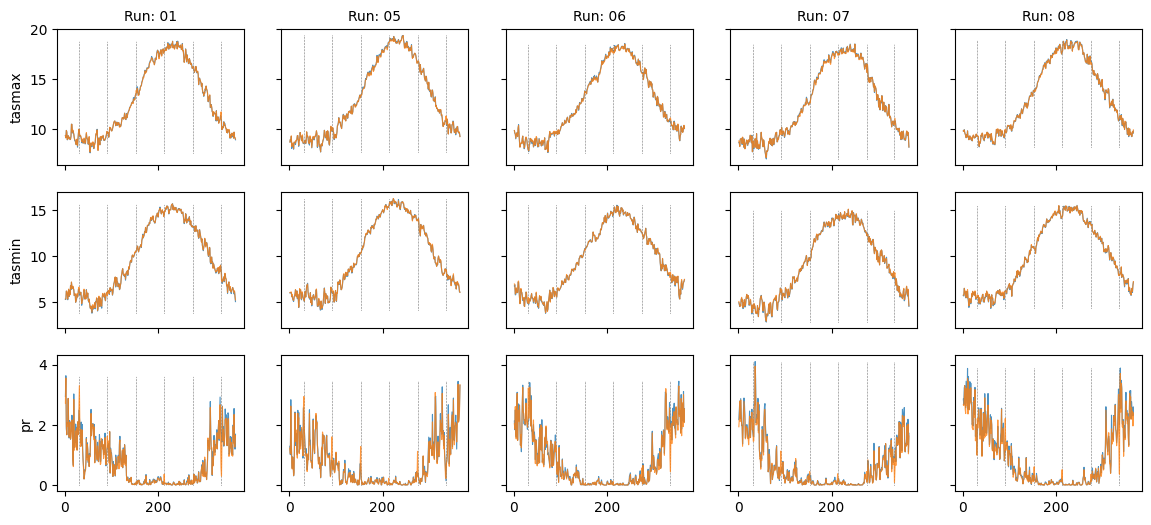

Plot diff: True; year: None; leap_year: True


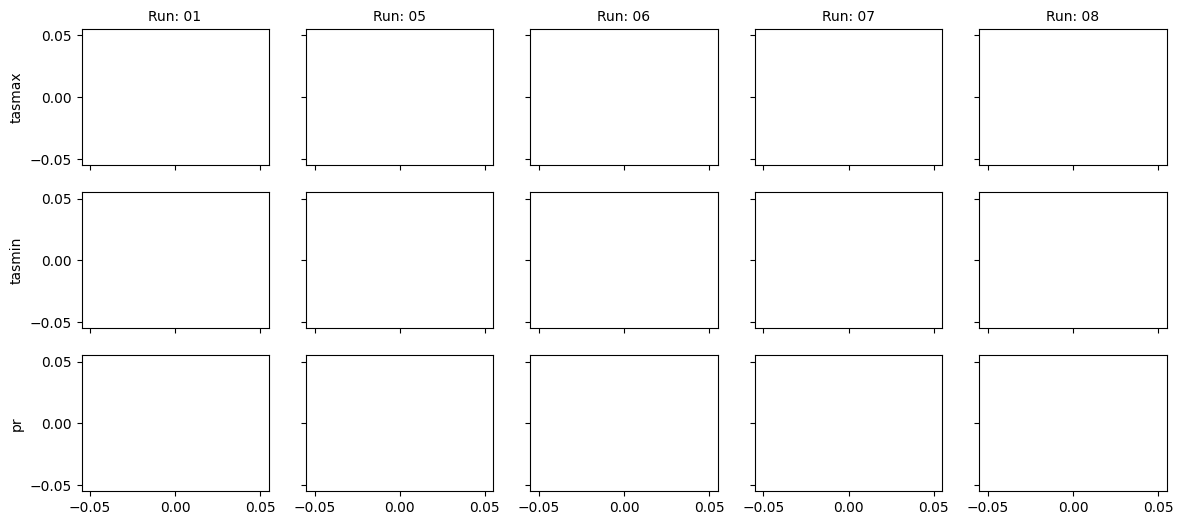

Plot diff: False; year: None; leap_year: False


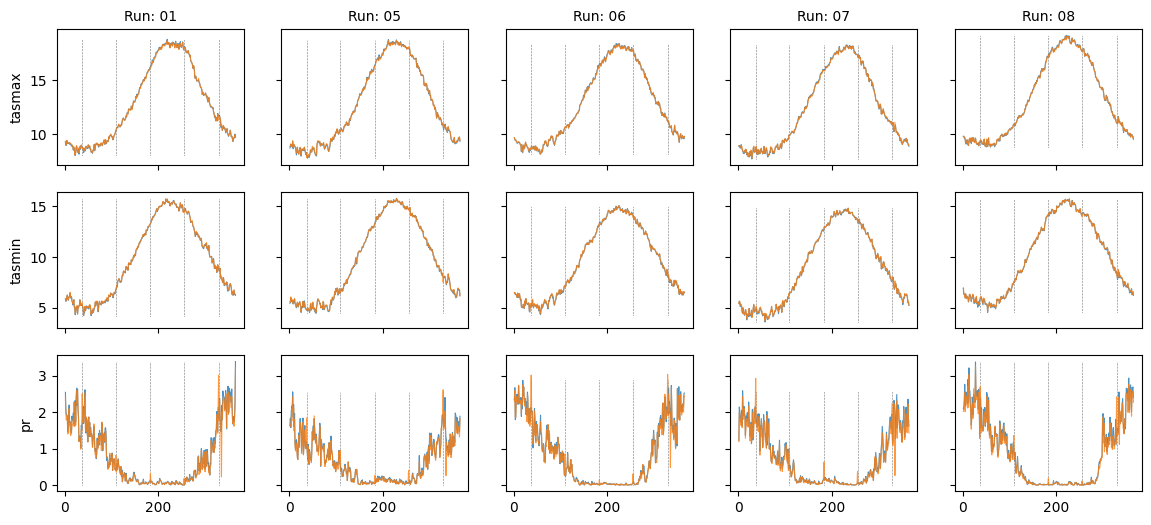

Plot diff: True; year: None; leap_year: False


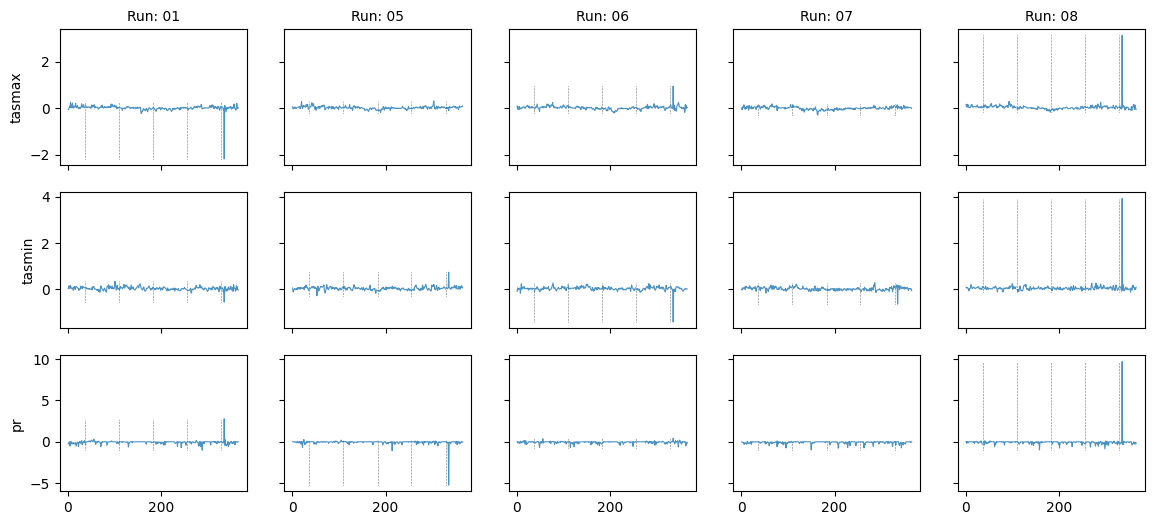

Plot diff: False; year: 1984; leap_year: True


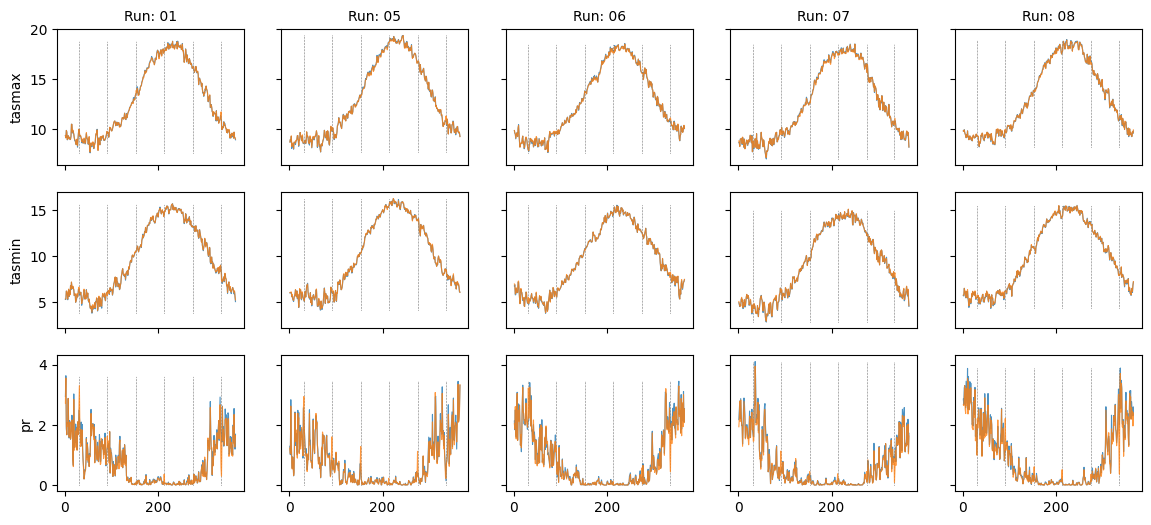

Plot diff: True; year: 1984; leap_year: True


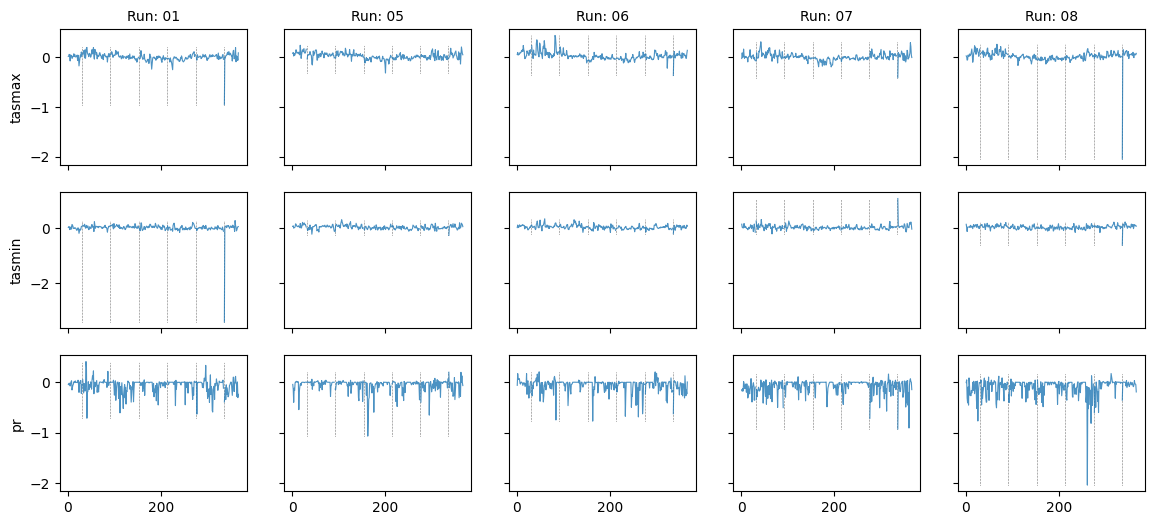

Plot diff: False; year: 1984; leap_year: False


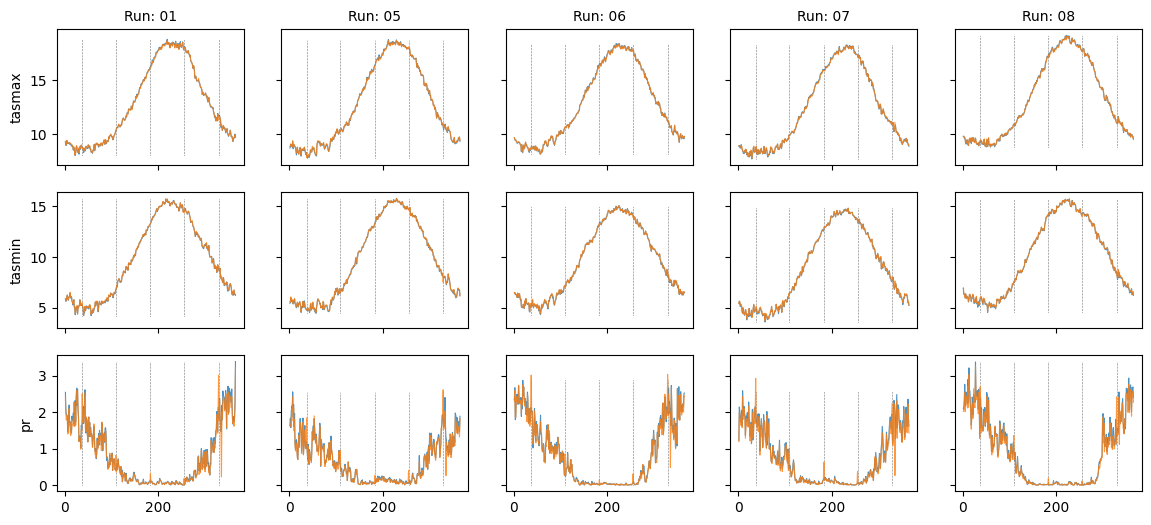

Plot diff: True; year: 1984; leap_year: False


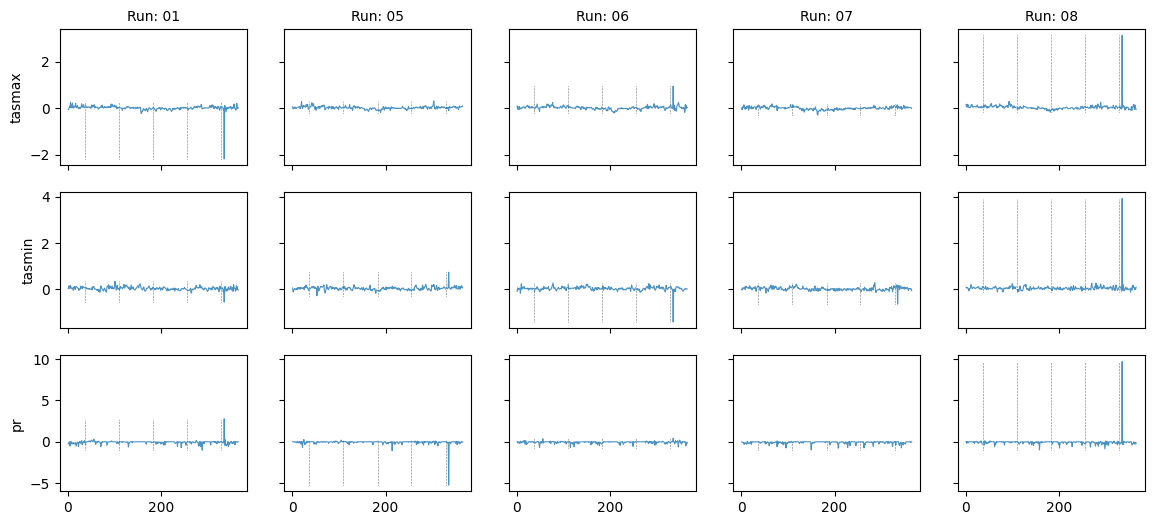

In [11]:
# Plot arrays
for year in [None, 1984]:
    for leap_year in [True, False]:
        for plot_diff in [False, True]:
            actual_year = year if leap_year and year is not None else 1983
            print(f"Plot diff: {plot_diff}; year: {year}; leap_year: {leap_year}")
            # Leap years, medians
            plot_array(data, year=actual_year, leap_year=leap_year, plot_diff=plot_diff)
            plt.show()